# Imports

In [374]:
%load_ext autoreload
%autoreload all
import os
os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.gridspec as gridspec
from Utils.Settings import n_splits, output_folder_calculations,class_to_division, class_to_broad_division, genes_families, neuron_cluster_groups_order, manifest, download_base, output_folder,  family_name, threshold_expression 
from Utils.Utils import broad_division_color_map, genes_cmap_rgb, cluster_groups_cmap, genes_cmap, percentage_above_threshold, decoddddddd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, classification_report
import shap
from sklearn.metrics import confusion_matrix
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [375]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Ensure horizontal scrollability
pd.set_option('display.max_colwidth', None) 

# Load data

In [376]:
%%time
metadata = manifest['file_listing']['WMB-10X']['metadata']

rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath.replace('example_genes_all_cells_expression.csv', f'{family_name}_genes_all_cells_expression.csv'))
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp = exp.sort_index(axis=1)


CPU times: user 25.3 s, sys: 4.52 s, total: 29.8 s
Wall time: 29.8 s


In [377]:
exp_with_tot = exp.copy()
exp_with_tot["Any Htr"] = exp[exp>threshold_expression].any(axis=1).replace({True: 10})


## Find membership df

In [378]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups

metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

rpath = metadata['cluster_annotation_term_set']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
term_set = pd.read_csv(file)
term_set

,label,name,description,order
0,CCN20230722_NEUR,neurotransmitter,Clusters are assigned based on the average expression of both neurotransmitter transporter genes and key neurotransmitter synthesizing enzyme genes.,0
1,CCN20230722_CLAS,class,The top level of cell type definition in the mouse whole brain taxonomy. It is primarily determined by broad brain region and neurotransmitter type. All cells within a subclass belong to the same class. Class provides a broader categorization of cell types.,1
2,CCN20230722_SUBC,subclass,The coarse level of cell type definition in the mouse whole brain taxonomy. All cells within a supertype belong to the same subclass. Subclass groups together related supertypes.,2
3,CCN20230722_SUPT,supertype,The second finest level of cell type definition in the mouse whole brain taxonomy. All cells within a cluster belong to the same supertype. Supertype groups together similar clusters.,3
4,CCN20230722_CLUS,cluster,The finest level of cell type definition in the mouse whole brain taxonomy. Cells within a cluster share similar characteristics and belong to the same supertype.,4


# Main divisions

In [379]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['dimension_reduction']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
maps = pd.read_csv(file)
maps.set_index('name',inplace=True)
print("number of maps:",len(maps))
#pd.DataFrame(maps["description"]).to_excel(Path(output_folder, 'Table_1.xlsx'), index=True)
maps

number of maps: 8


,label,description,number_of_cells,cluster_group_label
name,,,,
HY-EA-Glut-GABA,UMAP20230830-HY-EA-Glut-GABA,"Glutamatergic and GABAergic neurons in hypothalamus and extended amygdala, also including all non-pallium glutamatergic neurons in cerebral nuclei (1404 clusters)",295448,CCN20230722_HY-EA-Glut-GABA
MB-HB-CB-GABA,UMAP20230830-MB-HB-CB-GABA,"GABAergic neurons in midbrain, hindbrain, and cerebellum (1040 clusters)",186775,CCN20230722_MB-HB-CB-GABA
MB-HB-Glut-Sero-Dopa,UMAP20230830-MB-HB-Glut-Sero-Dopa,"Glutamatergic, serotonergic and dopaminergic neurons in midbrain and hindbrain (1431 clusters)",180669,CCN20230722_MB-HB-Glut-Sero-Dopa
NN-IMN-GC,UMAP20230830-NN-IMN-GC,"Non-neuronal cells, immature neurons, granule cells in dentate gyrus, olfactory bulb and cerebellum, and neurons in pineal gland (248 clusters)",1418529,CCN20230722_NN-IMN-GC
Pallium-Glut,UMAP20230830-Pallium-Glut,"Glutamatergic neurons from cerebral cortex (derived from the developmental pallium), including isocortex, hippocampal formation, olfactory areas, and cortical subplate (517 clusters)",1494801,CCN20230722_Pallium-Glut
Subpallium-GABA,UMAP20230830-Subpallium-GABA,"Telencephalic GABAergic neurons from cerebral cortex and cerebral nuclei, as well as some from the hypothalamic preoptic area, which are derived from the developmental subpallium (1051 clusters)",611423,CCN20230722_Subpallium-GABA
TH-EPI-Glut,UMAP20230830-TH-EPI-Glut,"Glutamatergic neurons from thalamus and epithalamus (i.e., medial and lateral habenula) (148 clusters)",126171,CCN20230722_TH-EPI-Glut
WholeBrain,UMAP20230830-WholeBrain,All cells in the whole mouse brain (5322 clusters),4042976,CCN20230722_WholeBrain


In [380]:
cell_with_membership = cell.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")

cell_with_membership["cluster_group_color"] = cell_with_membership["cluster_group_name"].map(cluster_groups_cmap)

cell_with_membership = cell_with_membership[cell_with_membership['cluster_group_name']!="WholeBrain"]

cell['neurotransmitter'].replace('', "None", inplace=True)

selected_genes = exp_with_tot.columns.sort_values()

joined = cell.join(exp_with_tot)

joined_boolean =  cell.join(exp_with_tot>threshold_expression)

subsampled = joined.loc[::30]

In [381]:
# CAREFUL assigning membership to neighborhood will duplicate some cells
joined_with_membership = cell_with_membership.join(exp_with_tot)

joined_boolean_with_membership =  cell_with_membership.join(exp_with_tot>threshold_expression)
subsampled_with_membership = joined_with_membership.loc[::30]

In [382]:
joined_boolean["Number of Htrs"] = joined_boolean[['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a',
       'Htr2b', 'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6',
       'Htr7']].sum(axis=1)

In [383]:
print(f"by differential prevalence of Htrs in each neighborhood. "
               f"{round((joined_boolean[joined_boolean['Any Htr']]['Number of Htrs']>1).sum()/joined_boolean['Any Htr'].sum()*100, 2)}% "
               f"of Htr-transcribing cells exhibited RNA of at least "
               f"2 Htrs, therefore, only in a minority of cases a cell was found to transcribe uniquely one Htr "
               f"({round((joined_boolean[joined_boolean['Any Htr']]['Number of Htrs']==1).sum()/joined_boolean.shape[0]*100, 2)}% of the totality of cells, Figure 1G). "
               f"Surprisingly, {round((joined_boolean[joined_boolean['Any Htr']]['Number of Htrs']>=5).sum()/joined_boolean['Any Htr'].sum()*100,2)}% "
               f"of Htr-transcribing cells were found to exhibit RNA of at least 5 other Htrs.  "
               f"The extensive transcription of different Htr families within the same cell points at the complexity of the 5-HT system even "
               f"at the single cell dimension. \n")

by differential prevalence of Htrs in each neighborhood. 60.84% of Htr-transcribing cells exhibited RNA of at least 2 Htrs, therefore, only in a minority of cases a cell was found to transcribe uniquely one Htr (25.78% of the totality of cells, Figure 1G). Surprisingly, 7.4% of Htr-transcribing cells were found to exhibit RNA of at least 5 other Htrs.  The extensive transcription of different Htr families within the same cell points at the complexity of the 5-HT system even at the single cell dimension. 



In [384]:
expression_by_neurotransmitter = round(joined.groupby("neurotransmitter")[selected_genes].apply(percentage_above_threshold), 2)

In [385]:
expression_by_group = round(joined_with_membership.groupby("cluster_group_name")[selected_genes].apply(percentage_above_threshold), 2)

In [386]:
expression_by_class = round(joined_with_membership.groupby("class")[selected_genes].apply(percentage_above_threshold), 2)

In [387]:
expression_by_subclass = round(joined_with_membership.groupby("subclass")[selected_genes].apply(percentage_above_threshold), 2)

In [388]:

# Convert the DataFrame to a NumPy array
corr_matrix_np = expression_by_neurotransmitter.T.corr().to_numpy()

# Replace the diagonal elements with NaN
np.fill_diagonal(corr_matrix_np, np.nan)

# Convert the NumPy array back to a DataFrame if needed
corr_by_neurotransmitter = pd.DataFrame(corr_matrix_np, index=expression_by_neurotransmitter.index, columns=expression_by_neurotransmitter.index)


# Convert the DataFrame to a NumPy array
corr_matrix_np = expression_by_group.T.corr().to_numpy()

# Replace the diagonal elements with NaN
np.fill_diagonal(corr_matrix_np, np.nan)

# Convert the NumPy array back to a DataFrame if needed
corr_by_group = pd.DataFrame(corr_matrix_np, index=expression_by_group.index, columns=expression_by_group.index)

# Convert the DataFrame to a NumPy array
corr_matrix_np = expression_by_class.T.corr().to_numpy()

# Replace the diagonal elements with NaN
np.fill_diagonal(corr_matrix_np, np.nan)

# Convert the NumPy array back to a DataFrame if needed
corr_by_class = pd.DataFrame(corr_matrix_np, index=expression_by_class.index, columns=expression_by_class.index)


In [389]:
neurotransmitter_color_map = {}
for n in cell['neurotransmitter'].unique():
    neurotransmitter_color_map[n] = cell[cell['neurotransmitter'] == n]['neurotransmitter_color'][0]
genes_cmap_rgb["Any Htr"] = "#494949"

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [390]:
classification_cmap = joined.drop_duplicates(subset='subclass').set_index('subclass')['subclass_color'].to_dict()
classification_cmap.update(joined.drop_duplicates(subset='supertype').set_index('supertype')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='cluster').set_index('cluster')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='class').set_index('class')['class_color'].to_dict())


In [391]:
fam_cmap = {
    "Htr1/5": "#6a5acd",  # Slate Blue
    "Htr2": "#ff6347",   # Tomato Red
    "Htr4/6/7": "#ffd700",  # Gold
    "Htr3": "#20b2aa"    # Light Sea Green
}


In [392]:
general_cmap = genes_cmap_rgb | neurotransmitter_color_map | cluster_groups_cmap | classification_cmap | fam_cmap

In [393]:
_ = joined_boolean_with_membership

at_least_2_receptors_per_group = {}
for area in _['cluster_group_name'].unique():
    at_least_2_receptors_per_group[area] = (np.sum(_[_['cluster_group_name']==area][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=2)/np.sum(_[_['cluster_group_name']==area][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=1))*100



In [394]:
_ = joined_boolean_with_membership

at_least_2_receptors_per_group_and_gene = {}
for area in tqdm(joined_boolean_with_membership['cluster_group_name'].unique()):
    __ = joined_boolean_with_membership[joined_boolean_with_membership['cluster_group_name']==area]  
    for gene in selected_genes:
        at_least_2_receptors_per_group_and_gene[area,gene] = (np.sum(__[__[gene]==True][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=2)/np.sum(__[__[gene]==True][selected_genes[selected_genes!='Any Htr']].sum(axis=1)>=1))*100



  0%|          | 0/7 [00:00<?, ?it/s]

In [395]:
_ = joined_boolean[selected_genes[selected_genes!='Any Htr']]

In [396]:
at_least_2_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_2_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=2)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

at_least_3_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_3_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=3)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

at_least_4_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_4_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=4)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

at_least_5_receptors = {}
for gene in selected_genes[selected_genes!='Any Htr']:
    at_least_5_receptors[gene] = (np.sum(_[_[gene]==True].sum(axis=1)>=5)/np.sum(_[_[gene]==True].sum(axis=1)>=1))*100

In [397]:
at_least_2_receptors

{'Htr1a': 91.22923440357651,
 'Htr1b': 91.33249250693274,
 'Htr1d': 94.81127082583568,
 'Htr1f': 69.30762900291646,
 'Htr2a': 84.41670704031415,
 'Htr2b': 80.33565853995441,
 'Htr2c': 81.29387870218416,
 'Htr3a': 85.46000268789105,
 'Htr3b': 87.13182728052617,
 'Htr4': 86.93457673583833,
 'Htr5a': 90.96397349954918,
 'Htr5b': 90.14163791538043,
 'Htr6': 88.69143551898662,
 'Htr7': 87.7206165230132}

## Co-exp

In [398]:
coexp = {}
for gene_target in tqdm(selected_genes[selected_genes!='Any Htr']):
     for gene_to_check in selected_genes[selected_genes!='Any Htr']: 
         coexp[gene_target, gene_to_check] = joined_boolean[[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean[gene_target]==True).sum()

  0%|          | 0/14 [00:00<?, ?it/s]

In [399]:
# coloc = pd.DataFrame.from_dict(coexp, orient='index', columns=['Colocalized (%)'])
# coloc[['Gene1', 'Gene2']] = pd.DataFrame(coloc.index.tolist(), index=coloc.index)
# coloc = coloc.reset_index(drop=True)

# # Reorder the columns for clarity
# coloc = coloc[['Gene1', 'Gene2', 'Colocalized (%)']]
# coloc["Colocalized (%)"] = coloc["Colocalized (%)"] * 100

# coloc['Gene1'] = pd.Categorical(coloc['Gene1'], categories=selected_genes[selected_genes!='Any Htr'], ordered=True)

# coloc['Gene2'] = pd.Categorical(coloc['Gene2'], categories=selected_genes[selected_genes!='Any Htr'], ordered=True)

In [400]:
# coloc.to_pickle(f"{output_folder_calculations}/total_colocalization_{family_name}.pkl")

In [401]:
coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization_{family_name}.pkl")

In [402]:

# out = {}
# for neigh in tqdm(joined_boolean_with_membership["cluster_group_name"].unique()):
#     sub_jo = joined_boolean_with_membership[joined_boolean_with_membership["cluster_group_name"]==neigh]
#     coexp = {}
#     for gene_target in selected_genes[selected_genes!='Any Htr']:
#          for gene_to_check in selected_genes[selected_genes!='Any Htr']: 
#              coexp[gene_target, gene_to_check] = sub_jo [[gene_target, gene_to_check]].all(axis=1).sum()/(sub_jo [gene_target]==True).sum()

#     coloc = pd.DataFrame.from_dict(coexp, orient='index', columns=['Colocalized (%)'])
#     coloc[['Gene1', 'Gene2']] = pd.DataFrame(coloc.index.tolist(), index=coloc.index)
#     coloc = coloc.reset_index(drop=True)
    
#     # Reorder the columns for clarity
#     coloc = coloc[['Gene1', 'Gene2', 'Colocalized (%)']]
#     coloc["Colocalized (%)"] = coloc["Colocalized (%)"] * 100
    
#     coloc['Gene1'] = pd.Categorical(coloc['Gene1'], categories=selected_genes[selected_genes!='Any Htr'], ordered=True)
    
#     coloc['Gene2'] = pd.Categorical(coloc['Gene2'], categories=selected_genes[selected_genes!='Any Htr'], ordered=True)
#     out[neigh] = coloc

In [403]:
# with open(f"{output_folder_calculations}/total_colocalization_{family_name}_by_neigh.pkl", "wb") as pkl_file:
#     pickle.dump(out, pkl_file)

In [404]:
with open(f"{output_folder_calculations}/total_colocalization_{family_name}_by_neigh.pkl", "rb") as pkl_file:
    coloc_by_neigh = pickle.load(pkl_file)

# Expression genes

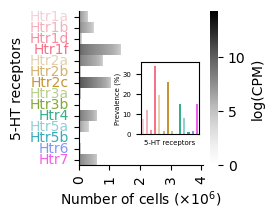

In [405]:
def expr_genes_whole_brain(ax, exp):
    sns.heatmap(pd.DataFrame(np.sort(exp.values, axis=0)[::-200], columns=exp.columns, 
                                  index=exp.reset_index().index[::200]).T, xticklabels=5000, yticklabels=True, cbar_kws={'label': 'log(CPM)'}, cmap="Greys", ax=ax)

    ax.set_ylabel("5-HT receptors")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    ax.set_xticklabels([int(int(text.get_text())/1000000) for text in ax.get_xticklabels()])
    ax.set_xlabel(r"Number of cells ($\times 10^6$)")
    
    colors_list = [genes_cmap_rgb[receptor] for receptor in exp.columns]
    
    for ytick in ax.get_yticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    
    axins = ax.inset_axes( [0.5, 0.2, 0.47, 0.47])
    (((exp>threshold_expression).sum(axis=0)/exp.shape[0])*100).plot.bar(ax=axins, color=colors_list)
    axins.set_xlabel("5-HT receptors", fontsize=5)
    axins.set_xticklabels([])
    axins.set_xticks([])
    axins.tick_params(axis='y', labelsize=5) 
    axins.set_ylabel("Prevalence (%)", fontsize=5, labelpad=1)
    
    #for xtick in axins.get_xticklabels():
    #   xtick.set_color(genes_cmap_rgb[xtick.get_text()])

fig, ax = plt.subplots(figsize=(2,2))
expr_genes_whole_brain(ax, exp)

## Difference between UMAP distribtion

In [406]:
def diff_umap_ABC_groups(fig, axs):
    _ = subsampled_with_membership.dropna()
    
    legend_handles = []
    
    # Create a Patch (a colored box) for each name and color, and add it to legend_handles
    for name in neuron_cluster_groups_order:
        legend_handles.append(mpatches.Patch(color=cluster_groups_cmap[name], label=name))
    
    axs[0].set_title('Neighborhoods')
    
    axs[0].scatter(_['x'], _['y'], c=_["cluster_group_color"], s=0.1, alpha=.3, marker='.')
    axs[0].axis('off')

    _ = subsampled.dropna()

    axs[1].scatter(_['x'], _['y'], c=_[genes_families[list(genes_families.keys())[0]]].max(axis=1), s=0.1, marker='.', cmap="Reds", zorder=1)
    
    axs[1].axis('off')
    axs[1].set_title(f'{list(genes_families.keys())[0]} family')
    
    axs[2].scatter(_['x'], _['y'], c=_[genes_families[list(genes_families.keys())[1]]].max(axis=1), s=0.1, marker='.', cmap='YlOrBr', zorder=1)
    
    axs[2].axis('off')
    axs[2].set_title(f'{list(genes_families.keys())[1]} family')

    fig.legend(handles=legend_handles, title='Neighborhoods', ncol=1, loc='upper left', bbox_to_anchor=(.25, 1),
               handlelength=.5, handletextpad=0.1, borderaxespad=0.1, framealpha=.2, fontsize=6, title_fontsize=6)



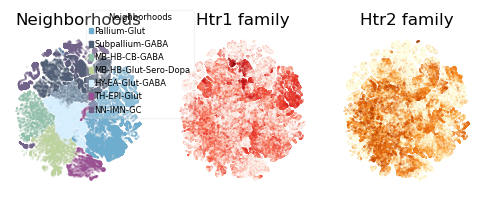

In [407]:
fig, axs = plt.subplots(1,3, figsize=(6,2))
diff_umap_ABC_groups(fig, axs)

## Decoding power

In [408]:

##%%time
## slow
#sel = "neurotransmitter"#"cluster_group_name"#"neurotransmitter"

#cm_neurotransmitter, shap_matrix_neurotransmitter, accuracy_neurotransmitter, report_neurotransmitter = decoddddddd(joined_boolean, sel, selected_genes, n_splits)

In [409]:
# with open(Path(output_folder_calculations, 'output_neurotransmitter.pkl'), 'wb') as f:
#     pickle.dump({
#         'cm_neurotransmitter': cm_neurotransmitter,
#         'shap_matrix_neurotransmitter': shap_matrix_neurotransmitter,
#         'accuracy_neurotransmitter': accuracy_neurotransmitter,
#         'report_neurotransmitter': report_neurotransmitter
#     }, f)

In [410]:
with open(Path(output_folder_calculations, 'output_neurotransmitter.pkl'), 'rb') as f:
    data = pickle.load(f)

cm_neurotransmitter = data['cm_neurotransmitter']
shap_matrix_neurotransmitter = data['shap_matrix_neurotransmitter']
accuracy_neurotransmitter = data['accuracy_neurotransmitter']
report_neurotransmitter = data['report_neurotransmitter']

The following takes long, we load a pre computed file

In [411]:
##%%time
#sel = "class"#"cluster_group_name"#"neurotransmitter"

#cm_class, shap_matrix_class, accuracy_class, report_class = decoddddddd(joined_boolean, sel, selected_genes, n_splits)

In [412]:
# with open(Path(output_folder_calculations, 'output_class.pkl'), 'wb') as f:
#     pickle.dump({
#         'cm_neurotransmitter': cm_class,
#         'shap_matrix_neurotransmitter': shap_matrix_class,
#         'accuracy_neurotransmitter': accuracy_class,
#         'report_neurotransmitter': report_class
#     }, f)

In [413]:
with open(Path(output_folder_calculations, 'output_class.pkl'), 'rb') as f:
    data = pickle.load(f)

cm_class = data['cm_neurotransmitter']
shap_matrix_class = data['shap_matrix_neurotransmitter']
accuracy_class = data['accuracy_neurotransmitter']
report_class = data['report_neurotransmitter']

In [414]:
# %%time
# sel = "cluster_group_name"#"neurotransmitter"

# cm_neighnborhood, shap_matrix_neighnborhood, accuracy_neighnborhood, report_neighnborhood = decoddddddd(joined_boolean_with_membership, sel, selected_genes, n_splits)

In [415]:
# with open(Path(output_folder_calculations, 'output_neighnborhood.pkl'), 'wb') as f:
#     pickle.dump({
#         'cm_neighnborhood': cm_neighnborhood,
#         'shap_matrix_neighnborhood': shap_matrix_neighnborhood,
#         'accuracy_neighnborhood': accuracy_neighnborhood,
#         'report_neighnborhood': report_neighnborhood
#     }, f)

In [416]:
with open(Path(output_folder_calculations, 'output_neighnborhood.pkl'), 'rb') as f:
    data = pickle.load(f)

cm_neighborhood = data['cm_neighnborhood']
shap_matrix_neighborhood = data['shap_matrix_neighnborhood']
accuracy_neighborhood = data['accuracy_neighnborhood']
report_neighborhood = data['report_neighnborhood']

## Expression across neurotransmitter types and regions 

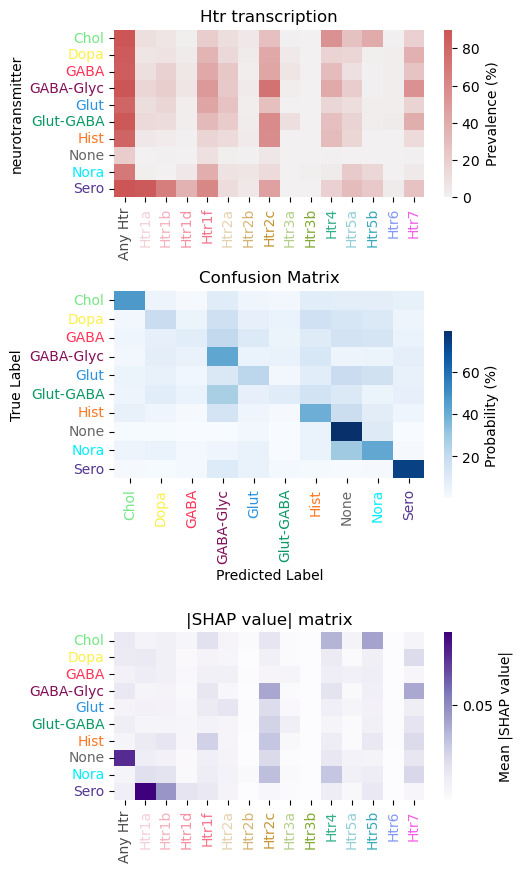

In [417]:
sel = "neurotransmitter"
def expr_genes_by_sel(axs, sel, joined, cm, shap_matrix):

    cax = sns.heatmap(joined.groupby(sel)[selected_genes].apply(percentage_above_threshold),
            cmap=sns.light_palette("#CC5656", as_cmap=True),  xticklabels=True, yticklabels=True, ax=axs[0],vmax=90, cbar_kws={'label': 'Prevalence (%)', "shrink": 1, "location": "right", "pad":0.05})

    sns.heatmap(cm, cmap="Blues", ax=axs[1],  xticklabels=True, yticklabels=True, cbar_kws={'label': 'Probability (%)', "shrink": 1, "location": "right", "pad":0.05}, )
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xlabel('Predicted Label')
    axs[1].set_ylabel('True Label')

    sns.heatmap(shap_matrix, cmap="Purples", xticklabels=True, yticklabels=True, ax=axs[2], cbar_kws={'label': 'Mean |SHAP value|', "shrink": 1, "location": "right", "pad":0.05, "ticks": [0.05]})
    axs[2].set_title('|SHAP value| matrix')
    axs[0].set_title('Htr transcription')

    
    for ax in axs:
        for ytick in ax.get_xticklabels():
            if ytick.get_text() in list(general_cmap.keys()):
                ytick.set_color(general_cmap[ytick.get_text()])
        for ytick in ax.get_yticklabels():
            if ytick.get_text() in list(general_cmap.keys()):
                ytick.set_color(general_cmap[ytick.get_text()])

    
fig, axs = plt.subplots(3,1, figsize=(5,10))
sel = "neurotransmitter"
expr_genes_by_sel(axs, sel, joined, cm_neurotransmitter, shap_matrix_neurotransmitter)
fig.subplots_adjust(hspace=0.8) 
#fig.tight_layout(pad=0.5)
# Get current position of the middle subplot
pos = axs[1].get_position()

# Modify the position parameters as needed (left, bottom, width, height)
# For example, to move the subplot up and increase its height:
new_pos = [pos.x0, pos.y0 + 0.02, pos.width, pos.height + 0.02]

# Set the new position
axs[1].set_position(new_pos)


## Expression across classes

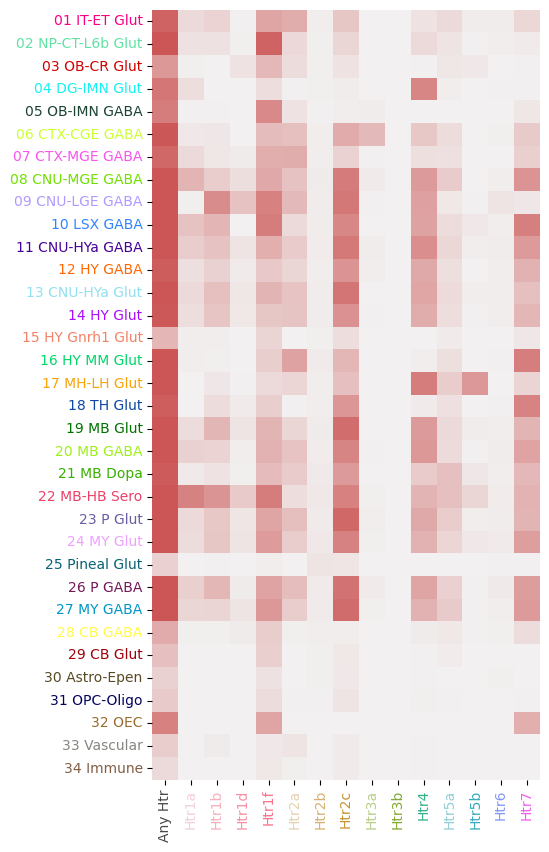

In [475]:
def expr_genes_by_classes(ax): 
    cax = sns.heatmap(joined.groupby("class")[selected_genes].apply(percentage_above_threshold),
                yticklabels=True,  cmap=sns.light_palette("#CC5656", as_cmap=True), ax=ax, cbar=False, vmax=90, xticklabels=True)
    for ytick in ax.get_xticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        ytick.set_color(classification_cmap[ytick.get_text()])

    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel("")
        

fig, ax = plt.subplots(figsize=(5,10))
expr_genes_by_classes(ax)

# Correlation

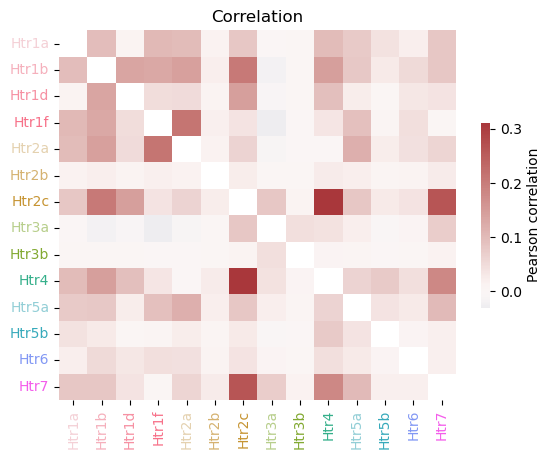

In [419]:
def corr_genes(ax): 
    _ = exp.corr()
    sns.heatmap(_[_<1],  ax=ax, cbar_kws={'label': 'Pearson correlation', "shrink": 0.5}, center=0, cmap="vlag", xticklabels=True, yticklabels=True, )
    for ytick in ax.get_xticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    ax.set_title("Correlation")

fig, ax = plt.subplots()
corr_genes(ax)

# Co-expression

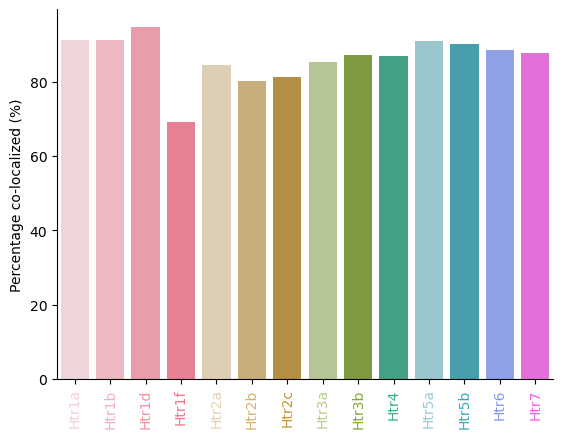

In [420]:
def plot_coloc(data, ax):
    sns.barplot(data=data,x="index", hue="index", palette=genes_cmap, y=data.columns[1], ax=ax)
    ax.set_xlabel("5-HT receptors")
    ax.set_ylabel(data.columns[1])
    ax.tick_params(axis='x', rotation=90)
    plt.draw()
    
    for ytick in ax.get_xticklabels():
        ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    sns.despine()
    ax.set_xlabel("")
    
fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_2_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

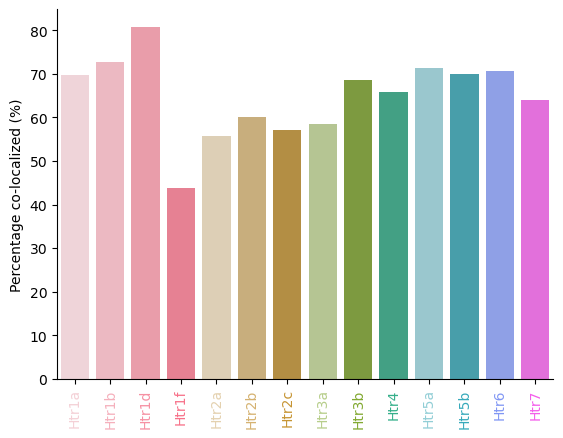

In [421]:

fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_3_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

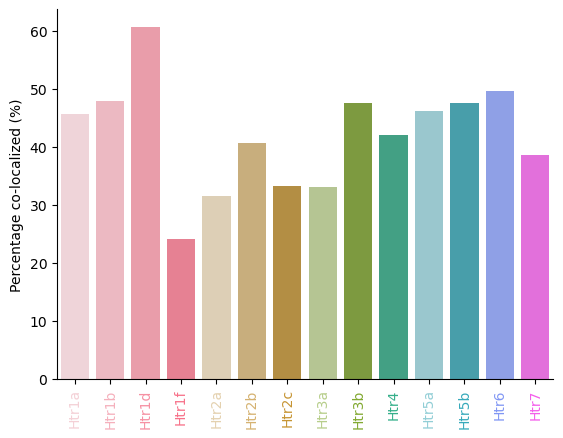

In [422]:

fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_4_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

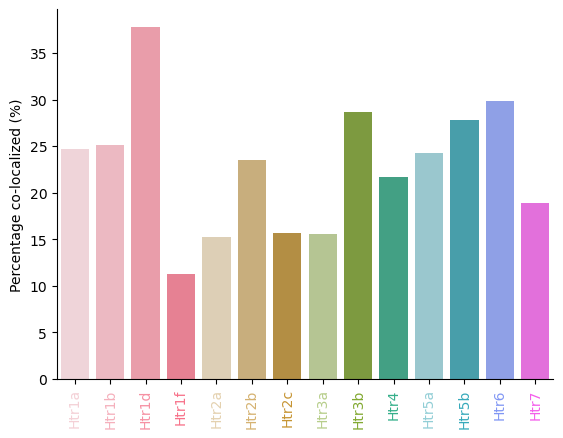

In [423]:

fig, ax = plt.subplots()
plot_coloc(pd.DataFrame.from_dict(at_least_5_receptors, orient="index", columns=["Percentage co-localized (%)"]).reset_index(), ax)

In [424]:
def scatterheat_coloc(ax, coloc, max_size_circle=50):
  
    coloc['Gene1'] = pd.Categorical(coloc['Gene1'], categories=selected_genes, ordered=True)
    
    coloc['Gene2'] = pd.Categorical(coloc['Gene2'], categories=selected_genes, ordered=True)
    
    
    sns.scatterplot(data=coloc[coloc["Colocalized (%)"]<100].sort_values(by=["Gene1", "Gene2"]),
            y="Gene1", x="Gene2", hue="Colocalized (%)", size="Colocalized (%)",
            palette="vlag",  edgecolor=".7",  sizes=(1, max_size_circle), ax=ax , hue_norm=(0,75)
           )
    ax.set(xlabel="", ylabel="")
    sns.despine(ax=ax, left=True, bottom=True)
    ax.margins(.02)
    plt.draw()
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    for label in ax.get_xticklabels():
        # Your code to modify the x-tick labels goes here
        label.set_color(genes_cmap_rgb[label.get_text()])
    for label in ax.get_yticklabels():
        # Your code to modify the x-tick labels goes here
        label.set_color(genes_cmap_rgb[label.get_text()])
    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [f"{label}%" if label.isdigit() else label for label in labels]
    ax.legend(handles, new_labels, bbox_to_anchor=(1, 0.2), ncol=1,  handletextpad=0, labelspacing=0.5, borderpad=0.3, fontsize=6)

    ax.set_title("Co-localization")

## Co-localization (percentage cells expressing y receptor also express x receptor?)

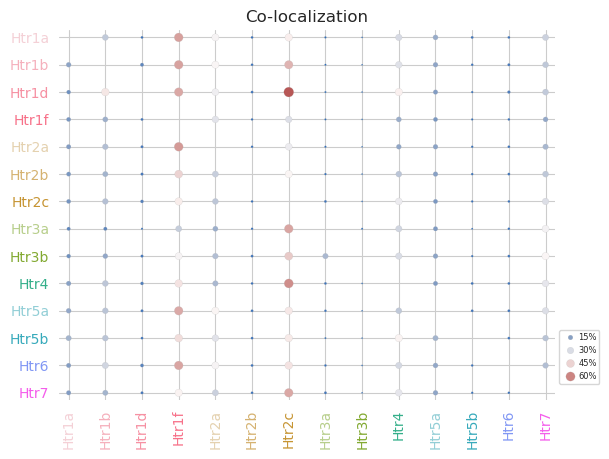

In [425]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots()
    scatterheat_coloc(ax, coloc)

In [426]:
%%time
by_fam = pd.concat([joined_with_membership[['Htr1a', 'Htr1b', 'Htr1d', 'Htr1f','Htr5a', 'Htr5b']].sum(axis=1),
              joined_with_membership[['Htr2a',
       'Htr2b', 'Htr2c']].sum(axis=1),
              joined_with_membership[['Htr4','Htr6',
       'Htr7']].sum(axis=1),
              joined_with_membership[['Htr3a','Htr3b']].sum(axis=1), joined_with_membership["class"], joined_with_membership["subclass"], joined_with_membership["supertype"], joined_with_membership["cluster_group_name"]], axis=1)

by_fam.columns = ["Htr1/5", "Htr2", "Htr4/6/7", "Htr3", "class", "subclass", "supertype","cluster_group_name"]
by_fam["Primary Htr family"] = by_fam[["Htr1/5", "Htr2", "Htr4/6/7", "Htr3"]].idxmax(axis=1)

CPU times: user 6.18 s, sys: 1.27 s, total: 7.44 s
Wall time: 7.42 s


## principal effector piecharts

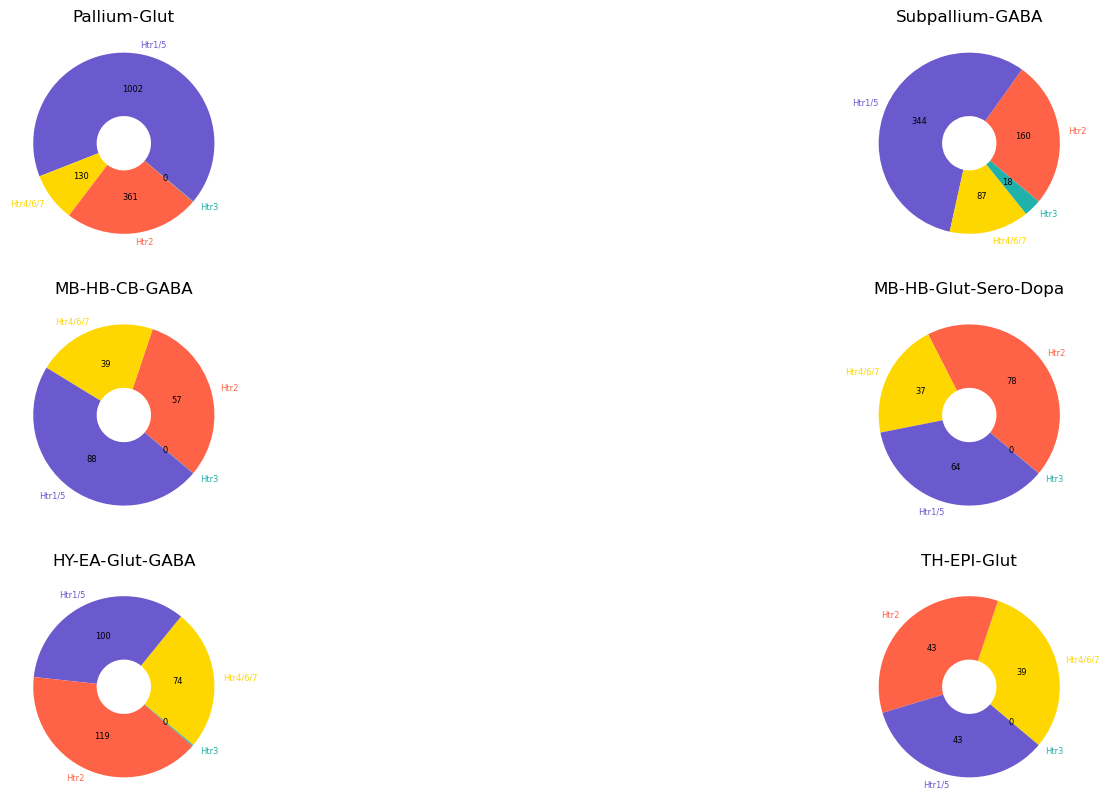

In [427]:

def pie_plots(axs):
    axs = axs.flatten()  # Flatten the array of axes for easy indexing
    
    def absolute_value(val, data):
        a = round(val/100.*data.sum(), 0)/1000
        return int(a)
        
    for i, group in enumerate(['Pallium-Glut',
     'Subpallium-GABA',
     'MB-HB-CB-GABA',
     'MB-HB-Glut-Sero-Dopa',
     'HY-EA-Glut-GABA',
     'TH-EPI-Glut']):
        group_data = by_fam[by_fam["cluster_group_name"] == group]
        values = group_data["Primary Htr family"].value_counts(sort=False)
        labels = values.index
        colors = [general_cmap[label] for label in labels if label in general_cmap]
    
        wedges, texts, autotexts = axs[i].pie(values, labels=labels, autopct=lambda val: absolute_value(val, values), 
                   wedgeprops=dict(width=0.7), startangle=-40, colors=colors, textprops={'fontsize': 6})
        axs[i].set_title(group)

        for text, color in zip(texts, colors):
            text.set_color(color)
            text.set_fontsize(6)
    
    # Hide the unused subplot
    axs[-1].axis('off')
    
fig, axs = plt.subplots(3, 2, figsize=(20, 10))  # 2 rows, 4 columns
pie_plots(axs)

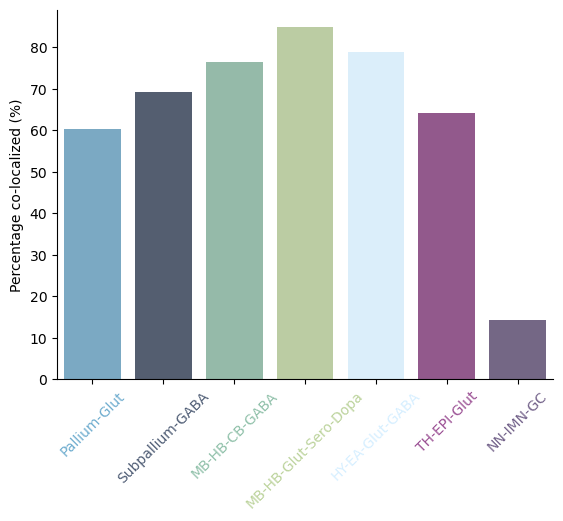

In [428]:
def plot_coloc_by_group( ax):
    sns.barplot(data=pd.DataFrame.from_dict(at_least_2_receptors_per_group, orient="index", columns=["Percentage co-localized (%)"]).reset_index(),x="index", hue="index",  palette=cluster_groups_cmap, ax=ax, order = neuron_cluster_groups_order, y="Percentage co-localized (%)")
    
    ax.tick_params(axis='x', rotation=45)
    sns.despine(ax=ax)
    plt.draw()
    for label in ax.get_xticklabels():
        # Your code to modify the x-tick labels goes here
        label.set_color(cluster_groups_cmap[label.get_text()])
    ax.set_xlabel("")
fig, ax = plt.subplots()
plot_coloc_by_group( ax)

# Figure 1

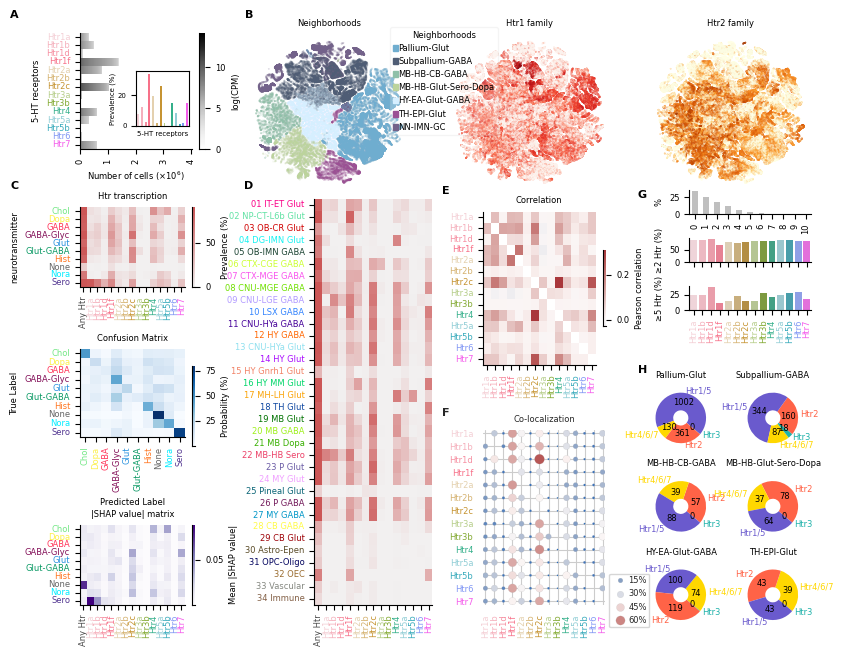

In [476]:
fig_width = 7.5
fontsize = 6
fig = plt.figure(figsize=(fig_width, fig_width*0.8))
gs = gridspec.GridSpec(4, 4, figure=fig, height_ratios=(.75,.5,.5,1))

subfig = fig.add_subfigure(gs[0,0])
ax = subfig.subplots()
subfig.suptitle("A", x=-.25, y=1.1, fontsize=8, fontweight='bold');
subfig.subplots_adjust(wspace=0,left=0.1, bottom=.25, top=.96, right=.85)
expr_genes_whole_brain(ax, exp)

subfig = fig.add_subfigure(gs[0,1:])
axs = subfig.subplots(1,3)
subfig.suptitle("B", x=0, y=1.1, fontsize=8, fontweight='bold');
subfig.subplots_adjust(wspace=0.25, left=0, bottom=0, top=.95, right=1)
diff_umap_ABC_groups(subfig, axs)
subfig.set_facecolor('none')

subfig = fig.add_subfigure(gs[1:4,0])
axs = subfig.subplots(3)
subfig.suptitle("C", x=-.25, y=1.02, fontsize=8, fontweight='bold');
sel="neurotransmitter"
expr_genes_by_sel(axs, sel,joined, cm_neurotransmitter, shap_matrix_neurotransmitter)
subfig.subplots_adjust(hspace=1, left=0.1, bottom=0.05, top=.96, right=.8) 
pos = axs[1].get_position()

# Modify the position parameters as needed (left, bottom, width, height)
# For example, to move the subplot up and increase its height:
new_pos = [pos.x0, pos.y0 + 0.02, pos.width, pos.height + 0.02]

# Set the new position
axs[1].set_position(new_pos)

subfig = fig.add_subfigure(gs[1:4,1])
axs = subfig.subplots()
subfig.suptitle("D", x=0, y=1.02, fontsize=8, fontweight='bold');
subfig.subplots_adjust(left=.35, bottom=0.05, top=.98, right=.98)
expr_genes_by_classes(axs)
axs.yaxis.set_label_coords(-0.35, 0.5) 

subfig = fig.add_subfigure(gs[1:3,2])
ax = subfig.subplots()
subfig.suptitle("E", x=0.05, y=1.02, fontsize=8, fontweight='bold');
subfig.subplots_adjust(left=0.25, bottom=.2, top=.9, right=1)
corr_genes(ax)
subfig.set_facecolor('none')

subfig = fig.add_subfigure(gs[1:3,3])
axs = subfig.subplots(3)
subfig.suptitle("G", x=.1, y=1, fontsize=8, fontweight='bold');
subfig.subplots_adjust( left=0.35, bottom=.45, top=1, right=1)
((joined_boolean["Number of Htrs"].value_counts()/joined_boolean.shape[0])*100).plot.bar(color=".75", ax= axs[0])
plot_coloc(pd.DataFrame.from_dict(at_least_2_receptors, orient="index", columns=["≥2 Htr (%)"]).reset_index(), axs[1])
axs[1].set_xticklabels("");
axs[0].set_ylabel("%");
plot_coloc(pd.DataFrame.from_dict(at_least_5_receptors, orient="index", columns=["≥5 Htr (%)"]).reset_index(), axs[2])
subfig.set_facecolor('none')

with sns.axes_style("whitegrid"):
    subfig = fig.add_subfigure(gs[3,2])
    ax = subfig.subplots()
    subfig.suptitle("F", x=.05, y=1, fontsize=8, fontweight='bold');
    subfig.subplots_adjust(left=.25, bottom=.1, top=.9, right=.9)
    scatterheat_coloc(ax, coloc)
    subfig.set_facecolor('none')

subfig = fig.add_subfigure(gs[3,3])
axs = subfig.subplots(3, 2)
subfig.suptitle("H", x=.1, y=1.2, fontsize=8, fontweight='bold');
subfig.subplots_adjust( top=1.1,bottom=0, right=1, wspace=0.2, hspace=0.4, left=.1)
pie_plots(axs)
subfig.set_facecolor('none')

# Resize all text in the figure
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

In [477]:
#fig.savefig(Path(output_folder, 'Figure_1.png'), bbox_inches='tight', dpi=300)
fig.savefig(Path(output_folder, 'Figure_1.pdf'), bbox_inches='tight')

## Supp

## 1

In [458]:
from scipy.stats import pearsonr as pearsonr
from scipy.stats import linregress

In [459]:
data = pd.concat([exp[exp>0].mean(), (((exp>threshold_expression).sum(axis=0)/exp.shape[0])*100)], axis=1)
data.columns = ["log(CPM)", "Prevalence (%)"]


def plot_supp_1(axs, data):
    sns.scatterplot(data=data.reset_index(), x="log(CPM)", y= "Prevalence (%)", hue="index", palette=genes_cmap_rgb, ax=axs[0])
    legend = axs[0].get_legend()
    legend.set_title("Genes", prop={'size': 5})  # Set the title font size
    plt.setp(legend.get_texts(), fontsize=5)  # Set the legend text font size
    
    # Re-create the legend to adjust the number of columns
    axs[0].legend(handles=legend.legendHandles, title="Genes", ncol=3, loc='upper center', fontsize=5, title_fontsize=5, bbox_to_anchor=(.5, 1.5))

    sns.regplot(data=data, x="log(CPM)", y= "Prevalence (%)", scatter=False, line_kws={ "color": "k", "alpha": .5}, ax=axs[0])
    
    r, p = pearsonr(data["log(CPM)"], data["Prevalence (%)"])
    
    s,_,_,_,_ = linregress(data["log(CPM)"], data["Prevalence (%)"])
    
    plt.text(.1, .8, f"R\u00b2={round(r ** 2, 2)}, p-value={'{:.2e}'.format(p)}, slope= {round(s,2)}", horizontalalignment='left',
            color='black', weight='semibold', transform = axs[0].transAxes, zorder=100, fontsize=5)
    if p<.05:
        plt.text(.1, .85, "*", size=15, color='black', weight='semibold', transform = axs[0].transAxes, zorder=10)
    
    sns.violinplot(exp[exp>0].loc[:,exp[exp>0].mean().sort_values(ascending=False).index], palette=genes_cmap_rgb, ax=axs[1], inner=None)
    plt.draw()
    for xtick in axs[1].get_xticklabels():
        xtick.set_color(genes_cmap_rgb[xtick.get_text()])
        xtick.set_rotation(90)
    axs[1].set_ylabel("Log(CPM)")

    for ax in axs:
        sns.despine(ax=ax)

#plt.tight_layout()

In [460]:
df = joined_with_membership

In [461]:
crosstab_neurotrans_neigh = pd.crosstab(df['neurotransmitter'], df['cluster_group_name'], normalize="index")*100
crosstab_neurotrans_class = pd.crosstab(df['neurotransmitter'], df['class'], normalize="index")*100
crosstab_neigh_class = pd.crosstab(df['cluster_group_name'], df['class'], normalize="index")*100

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


CPU times: user 3min 25s, sys: 1min 41s, total: 5min 7s
Wall time: 2min 55s


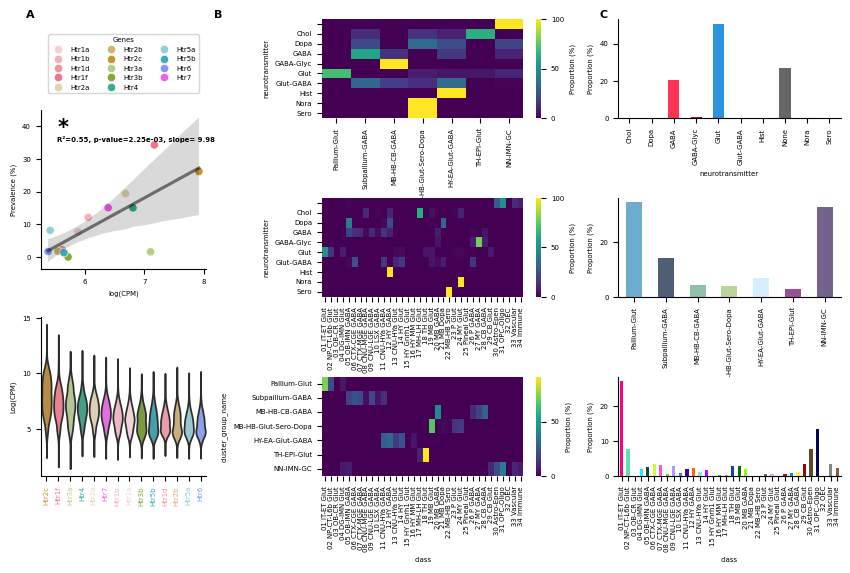

In [462]:
%%time
fig_width = 8
fontsize = 5
fig = plt.figure(figsize=(fig_width, fig_width*(8/14)))

gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[.7,1,1])

subfig = fig.add_subfigure(gs[0:,0])
subfig.subplots_adjust( left=0, bottom=0, top=.8, right=.8, hspace=0.3)
subfig.suptitle("A", x=-.05, y=1.02, fontsize=8, fontweight='bold');
axs = subfig.subplots(2)
plot_supp_1(axs, data)

subfig = fig.add_subfigure(gs[0:,1])
subfig.subplots_adjust( left=0.25, bottom=0, top=1, right=1.1, hspace=0.8)
subfig.suptitle("B", x=-.1, y=1.02, fontsize=8, fontweight='bold');
axs = subfig.subplots(3)

sns.heatmap(crosstab_neurotrans_neigh, ax=axs[0], cmap="viridis", xticklabels=True, yticklabels=True, cbar_kws={'label': 'Proportion (%)'})
sns.heatmap(crosstab_neurotrans_class, ax=axs[1], cmap="viridis", xticklabels=True, yticklabels=True, cbar_kws={'label': 'Proportion (%)'})
sns.heatmap(crosstab_neigh_class, ax=axs[2], cmap="viridis", xticklabels=True, yticklabels=True, cbar_kws={'label': 'Proportion (%)'})

subfig = fig.add_subfigure(gs[0:,2])
subfig.subplots_adjust(left=0.25, bottom=0, top=1, right=1, hspace=0.8)
subfig.suptitle("C", x=0.2, y=1.02, fontsize=8, fontweight='bold');
axs = subfig.subplots(3)

grouped_data = (joined.groupby("class").size()/joined.shape[0])*100

# Plot the ordered data
grouped_data.plot.bar(color=[classification_cmap[group] for group in grouped_data.index], ax=axs[2])

grouped_data = (joined.groupby("neurotransmitter").size() / joined.shape[0]) * 100

# Plot the ordered data
grouped_data.plot.bar(color=[neurotransmitter_color_map[group] for group in grouped_data.index], ax=axs[0])

# Group and calculate the percentage
grouped_data = (joined_with_membership.groupby("cluster_group_name").size() / joined_with_membership.shape[0]) * 100

# Reindex the grouped data to match the order specified in neuron_cluster_groups_order
ordered_data = grouped_data.reindex(neuron_cluster_groups_order)

# Plot the ordered data
ordered_data.plot.bar(color=[cluster_groups_cmap[group] for group in ordered_data.index if group in cluster_groups_cmap], ax=axs[1])

for ax in axs:
    ax.set_ylabel("Proportion (%)")
    sns.despine(ax=ax)
    
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

In [463]:
#fig.savefig(Path(output_folder, 'Supp_Figure_1.png'), bbox_inches='tight', dpi=300)
fig.savefig(Path(output_folder, 'Supp_Figure_1.pdf'), bbox_inches='tight')

## 2

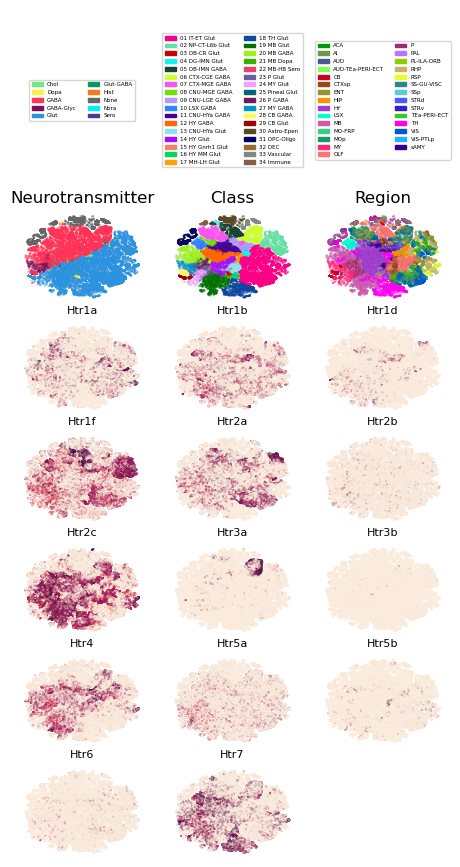

In [464]:
k = len(selected_genes) + 6

# Calculate number of rows for the grid
ncols = 3
nrows = int(np.ceil(k / ncols))

# Create a figure with the desired overall width and height
fig, axs = plt.subplots(nrows,ncols,figsize=(5.5,11), gridspec_kw={'height_ratios': [2,1,1,1,1,1,1],
                                                        })
for n, item in enumerate(["neurotransmitter", "class"]):      
    _ = subsampled[[item, item + "_color"]].drop_duplicates()
    _ = _.sort_values(item)
    # Create custom legend elements
    legend_elements = [mpatches.Patch(color=row[item + '_color'], label=row[item]) for x, row in _.iterrows()]
    axs[0,n].legend(handles=legend_elements, ncol=2, loc="center", fontsize=4)

_ = subsampled[["region_of_interest_acronym", "region_of_interest_color"]].drop_duplicates()
_ = _.sort_values("region_of_interest_acronym")
# Create custom legend elements
legend_elements = [mpatches.Patch(color=row["region_of_interest_color"], label=row["region_of_interest_acronym"]) for x, row in _.iterrows()]
axs[0,2].legend(handles=legend_elements, ncol=2, loc="center", fontsize=4)

axs[1,0].scatter(subsampled['x'], subsampled['y'], c=subsampled['neurotransmitter_color'], s=0.1, alpha=.3, marker='.')
axs[1,0].set_title("Neurotransmitter") 
axs[1,2].scatter(subsampled['x'], subsampled['y'], c=subsampled['region_of_interest_color'], s=0.1, alpha=.3, marker='.')
axs[1,2].set_title("Region") 
axs[1,1].scatter(subsampled['x'], subsampled['y'], c=subsampled['class_color'], s=0.1, alpha=.3, marker='.')
axs[1,1].set_title("Class") 

for n, gene in enumerate(selected_genes[selected_genes!='Any Htr']):
    row = n // ncols
    col = n % ncols
    sc = axs[row + 2, col ].scatter(subsampled['x'], subsampled['y'], c=subsampled[gene], s=0.1, marker='.', cmap="rocket_r")
    axs[row + 2, col].set_title(gene, fontsize=8) 

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

#plt.tight_layout()

In [465]:
#fig.savefig(Path(output_folder, 'Supp_Figure_2.png'), bbox_inches='tight', dpi=100)
fig.savefig(Path(output_folder, 'Supp_Figure_2.tiff'), bbox_inches='tight')

In [466]:
'''fig, axs = plt.subplots(2,3, figsize=(30,15))

sns.heatmap(expression_by_neurotransmitter.T.corr(), cmap="vlag", center=0, ax=axs[0,0], cbar=0)
sns.heatmap(expression_by_group.T.corr(),  cmap="vlag", center=0, ax=axs[0,1], cbar=0)
sns.heatmap(expression_by_class.T.corr(),  cmap="vlag", center=0, ax=axs[0,2], cbar=1)

sns.barplot(corr_by_neurotransmitter, palette=neurotransmitter_color_map, ax=axs[1,0])


# Reindex the grouped data to match the order specified in neuron_cluster_groups_order
ordered_data = corr_by_group.loc[neuron_cluster_groups_order]

sns.barplot(ordered_data, palette=cluster_groups_cmap, ax=axs[1,1])
# Plot the ordered data

sns.barplot(corr_by_class, palette=classification_cmap, ax=axs[1,2])

for ax in [axs[1,2], axs[1,1], axs[1,0]]:
    ax.set_ylabel("Mean r")

for ax in [axs[0,2], axs[0,1], axs[0,0]]:
    ax.set_title("Correlation matrix")
    
sns.despine()
plt.tight_layout()'''

'fig, axs = plt.subplots(2,3, figsize=(30,15))\n\nsns.heatmap(expression_by_neurotransmitter.T.corr(), cmap="vlag", center=0, ax=axs[0,0], cbar=0)\nsns.heatmap(expression_by_group.T.corr(),  cmap="vlag", center=0, ax=axs[0,1], cbar=0)\nsns.heatmap(expression_by_class.T.corr(),  cmap="vlag", center=0, ax=axs[0,2], cbar=1)\n\nsns.barplot(corr_by_neurotransmitter, palette=neurotransmitter_color_map, ax=axs[1,0])\n\n\n# Reindex the grouped data to match the order specified in neuron_cluster_groups_order\nordered_data = corr_by_group.loc[neuron_cluster_groups_order]\n\nsns.barplot(ordered_data, palette=cluster_groups_cmap, ax=axs[1,1])\n# Plot the ordered data\n\nsns.barplot(corr_by_class, palette=classification_cmap, ax=axs[1,2])\n\nfor ax in [axs[1,2], axs[1,1], axs[1,0]]:\n    ax.set_ylabel("Mean r")\n\nfor ax in [axs[0,2], axs[0,1], axs[0,0]]:\n    ax.set_title("Correlation matrix")\n    \nsns.despine()\nplt.tight_layout()'

## 3

In [467]:
#sel = "cluster_group_name"#"class"#"cluster_group_name"#"neurotransmitter"

#cm_neighborhood, shap_matrix_neighborhood, accuracy_neighborhood, report_neighborhood = decoddddddd(joined_boolean_with_membership, sel, selected_genes, n_splits)

In [468]:
#sel = "class"#"class"#"cluster_group_name"#"neurotransmitter"

#cm_class, shap_matrix_class, accuracy_class, report_class = decoddddddd(joined_boolean, sel, selected_genes, n_splits)

In [469]:

joined_with_membership["cluster_group_name"] = pd.Categorical(joined_with_membership["cluster_group_name"], categories=neuron_cluster_groups_order, ordered=True)


In [470]:
cm_neighborhood = cm_neighborhood.loc[neuron_cluster_groups_order]

In [471]:
cm_neighborhood = cm_neighborhood[neuron_cluster_groups_order]

In [472]:
shap_matrix_neighborhood = shap_matrix_neighborhood.loc[neuron_cluster_groups_order]


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


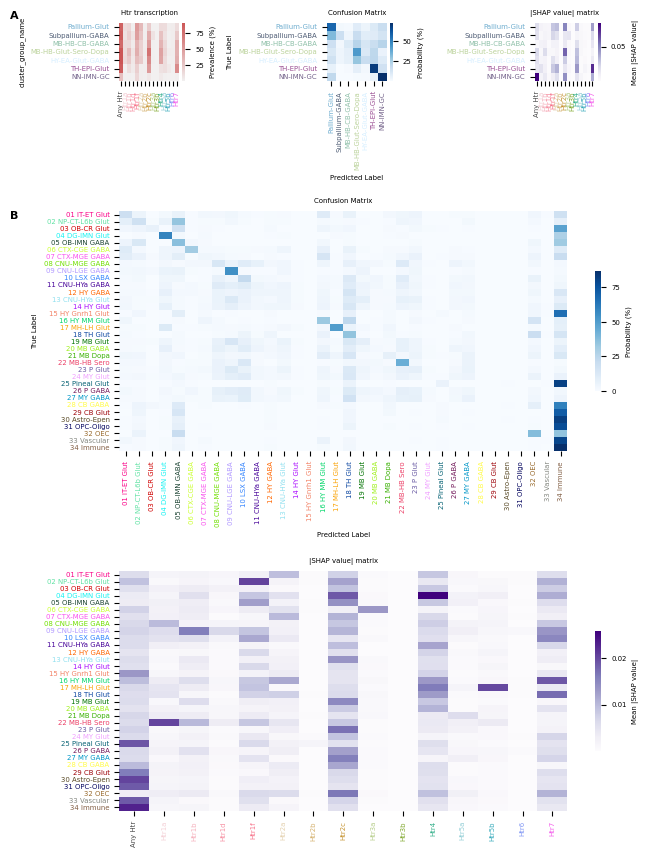

In [473]:
fontsize = 5
fig = plt.figure(figsize=(7, 11))

gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[.1,1])

subfig = fig.add_subfigure(gs[0,0:])
subfig.subplots_adjust(bottom=.3, wspace=1.8, left=.2)
subfig.suptitle("A", x=0.05, y=1.0, fontsize=8, fontweight='bold');
axs = subfig.subplots(1, 3)
sel = "cluster_group_name"
expr_genes_by_sel(axs, sel,joined_with_membership, cm_neighborhood, shap_matrix_neighborhood)

subfig = fig.add_subfigure(gs[1:,0:])
subfig.subplots_adjust( hspace=0.5, top=.9, right=1)
subfig.suptitle("B", x=0.05, y=.9, fontsize=8, fontweight='bold');
axs = subfig.subplots(2)

sns.heatmap(cm_class, cmap="Blues", ax=axs[0], cbar_kws={'label': 'Probability (%)', "shrink": 0.5, "location": "right", "pad":0.05}, xticklabels=True, yticklabels=True)
axs[0].set_title('Confusion Matrix')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

sns.heatmap(shap_matrix_class, cmap="Purples", ax=axs[1], cbar_kws={'label': 'Mean |SHAP value|', "shrink": 0.5, "location": "right", "pad":0.05}, xticklabels=True, yticklabels=True)
axs[1].set_title('|SHAP value| matrix')

for ax in axs:
    for ytick in ax.get_xticklabels():
        if ytick.get_text() in list(general_cmap.keys()):
            ytick.set_color(general_cmap[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in list(general_cmap.keys()):
            ytick.set_color(general_cmap[ytick.get_text()])

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

In [474]:
#fig.savefig(Path(output_folder, 'Supp_Figure_3.png'), bbox_inches='tight', dpi=300)
fig.savefig(Path(output_folder, 'Supp_Figure_3.pdf'), bbox_inches='tight')

## 4

0it [00:00, ?it/s]

0it [00:00, ?it/s]

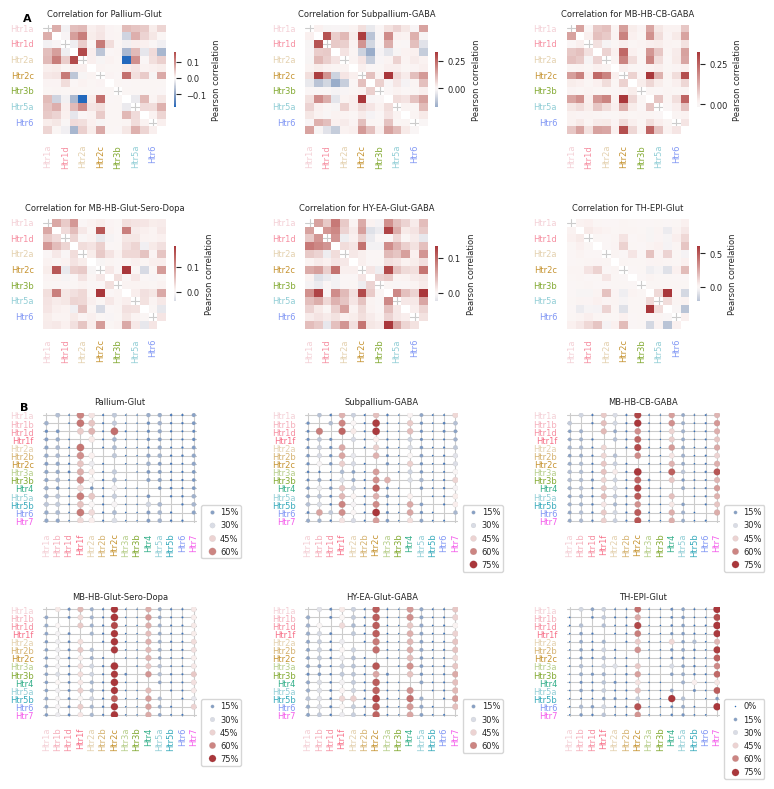

In [448]:
fontsize = 6
max_size_circle = 30
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 8))
    axs_flat = axs.flatten()
    for i, area in tqdm(enumerate(['Pallium-Glut',
     'Subpallium-GABA',
     'MB-HB-CB-GABA',
     'MB-HB-Glut-Sero-Dopa',
     'HY-EA-Glut-GABA',
     'TH-EPI-Glut'])):
        
        subset = joined_with_membership[joined_with_membership["cluster_group_name"] == area]
        correlation = subset[exp.columns].corr()
        sns.heatmap(correlation[correlation < 1], ax=axs_flat[i],center=0, cbar_kws={'label': 'Pearson correlation', "shrink": 0.5},  cmap="vlag")
        axs_flat[i].set_title(f"Correlation for {area}")

        for ytick in axs_flat[i].get_xticklabels():
            ytick.set_color(genes_cmap_rgb[ytick.get_text()])
        for ytick in axs_flat[i].get_yticklabels():
            ytick.set_color(genes_cmap_rgb[ytick.get_text()])
    
    for i, neigh in tqdm(enumerate(['Pallium-Glut',
     'Subpallium-GABA',
     'MB-HB-CB-GABA',
     'MB-HB-Glut-Sero-Dopa',
     'HY-EA-Glut-GABA',
     'TH-EPI-Glut'])):
            scatterheat_coloc(axs_flat[i+6], coloc_by_neigh[neigh], max_size_circle)
            axs_flat[i+6].set_title(neigh)
    
    plt.tight_layout()

axs_flat[0].text(-0.1, 1.1, "A", transform=axs_flat[0].transAxes, fontsize=8, fontweight='bold', va='top', ha='right')
axs_flat[6].text(-0.1, 1.1, "B", transform=axs_flat[6].transAxes, fontsize=8, fontweight='bold', va='top', ha='right')

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

In [449]:
#fig.savefig(Path(output_folder, 'Supp_Figure_4.png'), bbox_inches='tight', dpi=300)
fig.savefig(Path(output_folder, 'Supp_Figure_4.pdf'), bbox_inches='tight')

# Test linear models

In [60]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold,  cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

CPU times: user 16.3 ms, sys: 7.86 ms, total: 24.2 ms
Wall time: 152 ms


In [67]:
sel = "neurotransmitter"#"cluster_group_name"#"neurotransmitter"
    
def decode_linear(model, joined_boolean, sel):
    df = joined_boolean[[sel]+list(selected_genes)]
    
    df.set_index(sel, inplace=True)
    
    # Assuming 'df' is your DataFrame
    X = df # Features (Htr expression levels)
    y = df.index  # Target (neurotransmitter type)
    
    skf = StratifiedKFold(n_splits=n_splits)

    scorer = make_scorer(balanced_accuracy_score)
    scores = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=n_splits)
    
    accuracy = np.mean(scores)
    
    print(scores)
    print("Accuracy:", accuracy)

    cm = []
    
    shap_matrix =[]

    return cm, shap_matrix, accuracy, report

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 17.9 µs


In [70]:
%%time
model = LogisticRegression( class_weight='balanced', max_iter=500)
_, _,_, _ = decode_linear(model, joined_boolean, sel)

[0.35538003 0.39778327 0.31820146 0.43197249 0.38100228]
Accuracy: 0.3768679056633491
CPU times: user 10.2 s, sys: 2.41 s, total: 12.6 s
Wall time: 12min 2s


In [68]:
%%time

model = LinearDiscriminantAnalysis()
_, _,_, _= decode_linear(model, joined_boolean, sel)

[0.26927625 0.27245281 0.1974403  0.27644314 0.23073049]
Accuracy: 0.2492685971397365
CPU times: user 6.86 s, sys: 2.29 s, total: 9.15 s
Wall time: 38 s


# Cells expressing uniquely Htr1a

In [129]:
selected_genes

Index(['Any Htr', 'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f', 'Htr2a', 'Htr2b',
       'Htr2c', 'Htr3a', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'],
      dtype='object')

In [130]:
df = joined_boolean

<Axes: xlabel='class'>

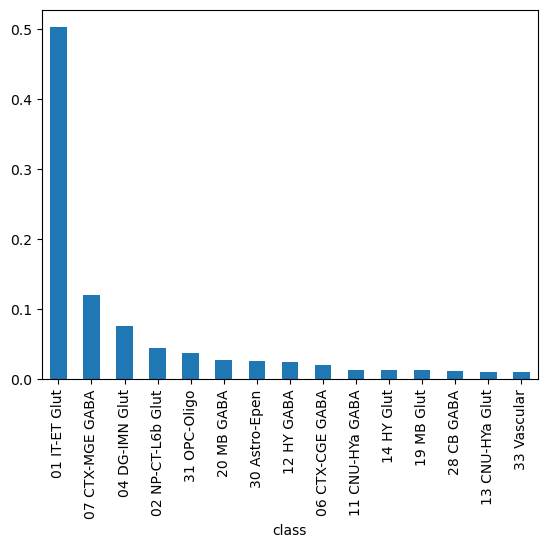

In [139]:
df[
    (df['Htr1a'] == True) &
    (df['Htr1b'] == False) &
    (df['Htr1d'] == False) &
    (df['Htr1f'] == False) &
    (df['Htr2a'] == False) &
    (df['Htr2b'] == False) &
    (df['Htr2c'] == False) &
    (df['Htr3a'] == False) &
    (df['Htr3b'] == False) &
    (df['Htr4'] == False) &
    (df['Htr5a'] == False) &
    (df['Htr5b'] == False) &
    (df['Htr6'] == False) &
    (df['Htr7'] == False)
]["class"].value_counts(normalize=True)[:15].plot.bar()

<Axes: xlabel='subclass'>

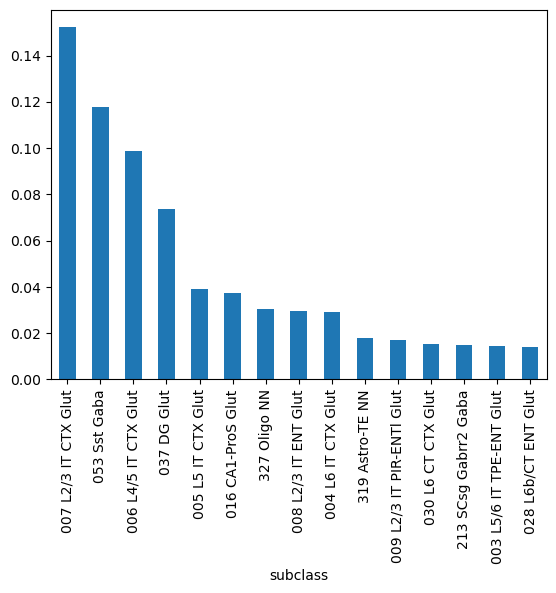

In [140]:
df[
    (df['Htr1a'] == True) &
    (df['Htr1b'] == False) &
    (df['Htr1d'] == False) &
    (df['Htr1f'] == False) &
    (df['Htr2a'] == False) &
    (df['Htr2b'] == False) &
    (df['Htr2c'] == False) &
    (df['Htr3a'] == False) &
    (df['Htr3b'] == False) &
    (df['Htr4'] == False) &
    (df['Htr5a'] == False) &
    (df['Htr5b'] == False) &
    (df['Htr6'] == False) &
    (df['Htr7'] == False)
]["subclass"].value_counts(normalize=True)[:15].plot.bar()

# Test dummy model

In [147]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix


## neighborhood

In [146]:
sel = "cluster_group_name"#"class"#"cluster_group_name"#"neurotransmitter"

df = joined_boolean_with_membership[[sel] + list(selected_genes)]

df.set_index(sel, inplace=True)

# Assuming 'df' is your DataFrame
X = df  # Features (Htr expression levels)
y = df.index  # Target (neurotransmitter type)

model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', n_jobs=20)

skf = StratifiedKFold(n_splits=n_splits)

scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=n_splits)

accuracy = np.mean(scores)

print(scores)
print("Accuracy:", accuracy)

[0.40650275 0.40716735 0.40639676 0.40859004 0.41198604]
Accuracy: 0.4081285887825496


In [148]:


# Initialize the Dummy Classifier
model = DummyClassifier(strategy='most_frequent')

skf = StratifiedKFold(n_splits=n_splits)

scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=n_splits)

accuracy = np.mean(scores)

print(scores)
print("Accuracy:", accuracy)

[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]
Accuracy: 0.14285714285714285


## neurotransmitter

In [149]:
sel = "neurotransmitter"#"class"#"cluster_group_name"#"neurotransmitter"

df = joined_boolean[[sel] + list(selected_genes)]

df.set_index(sel, inplace=True)

# Assuming 'df' is your DataFrame
X = df  # Features (Htr expression levels)
y = df.index  # Target (neurotransmitter type)

model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', n_jobs=20)

skf = StratifiedKFold(n_splits=n_splits)

scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=n_splits)

accuracy = np.mean(scores)

print(scores)
print("Accuracy:", accuracy)

[0.38198267 0.39775441 0.32061884 0.43692414 0.38927729]
Accuracy: 0.38531147190426385


In [150]:
# Initialize the Dummy Classifier
model = DummyClassifier(strategy='most_frequent')

skf = StratifiedKFold(n_splits=n_splits)

scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=n_splits)

accuracy = np.mean(scores)

print(scores)
print("Accuracy:", accuracy)

[0.1 0.1 0.1 0.1 0.1]
Accuracy: 0.1


## class

In [151]:
sel = "class"#"class"#"cluster_group_name"#"neurotransmitter"

df = joined_boolean[[sel] + list(selected_genes)]

df.set_index(sel, inplace=True)

# Assuming 'df' is your DataFrame
X = df  # Features (Htr expression levels)
y = df.index  # Target (neurotransmitter type)

model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', n_jobs=20)

skf = StratifiedKFold(n_splits=n_splits)

scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=n_splits)

accuracy = np.mean(scores)

print(scores)
print("Accuracy:", accuracy)

[0.2031853  0.19105829 0.17680463 0.1648937  0.14718454]
Accuracy: 0.17662529303396446


In [152]:


# Initialize the Dummy Classifier
model = DummyClassifier(strategy='most_frequent')

skf = StratifiedKFold(n_splits=n_splits)

scorer = make_scorer(balanced_accuracy_score)
scores = cross_val_score(model, X, y, cv=skf, scoring=scorer, n_jobs=n_splits)

accuracy = np.mean(scores)

print(scores)
print("Accuracy:", accuracy)

[0.02941176 0.02941176 0.02941176 0.02941176 0.02941176]
Accuracy: 0.029411764705882353
